### Importing Packages

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery, storage

# from utils import *
from ten_chart import *
import math
import talib

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from termcolor import colored as cl 

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)


from datetime import datetime, timedelta, date
import datetime

# Using graph_objects
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Extracting DATA

In [2]:
# present day
dt='20221206'

query = f"""

    WITH content_t AS (
        SELECT 
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time

        FROM (
            SELECT DISTINCT
            EXTRACT(DATE FROM DATETIME(date, "America/New_York")) as pub_date,
            EXTRACT(TIME from DATETIME(date, "America/New_York")) as pub_time,
            DATETIME(date, "America/New_York") as pub_date_time,
            LOWER(NaturalId) AS natid,
            title,
            RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent
        FROM
            `api-project-901373404215.Content.content`
        WHERE
            Visible is true
                AND type in (
                'blog',
                'blogslide',
                'magazine'
            )
        )
        WHERE 
        mostrecent = 1            ),

    ga_rt_sess AS (
            SELECT
                hour,
                minute,
                date as ga_date,
                fullvisitorid,
                COUNT(DISTINCT 
                  CONCAT(
                      CAST(fullvisitorid AS string),
                      CAST(visitid AS string),
                      CAST(hits.page.pagePath AS string),
                      CAST(visitStartTime AS string),
                      CAST(visitNumber AS string),
                      CAST(hits.hitNumber AS string))
                ) AS pageviews,
                CAST(MAX((IF(CDS.index=24,CDS.value,NULL))) AS STRING) AS natid,
                CAST(MAX((IF(CDS.index=107,CDS.value,NULL))) AS STRING) AS piano_id
            FROM
                `api-project-901373404215.206396628.ga_realtime_sessions_{dt}`,
                UNNEST(hits) AS hits,
                UNNEST(hits.customdimensions) AS CDS
            WHERE
                hits.type = 'PAGE'
            GROUP BY
                fullvisitorid, 
                hits.page.pagePath,
                trafficSource.source,
                trafficSource.medium,
                trafficSource.campaign,
                hits.hour,
                hits.minute,
                ga_date
        )

        SELECT 
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time,
            SUM(pageviews) AS pageviews,
            hour,
            minute,
            ga_date

        FROM (
            SELECT
                ga_rt_sess.natid,
                title,
                ga_rt_sess.piano_id AS ga_piano_id,
                SUM(pageviews) AS pageviews,
                hour,
                minute,
                ga_date,
                pub_date,
                pub_time,
                pub_date_time
            FROM 
                ga_rt_sess 
            INNER JOIN
                content_t
            ON
                LOWER(ga_rt_sess.natid) = LOWER(content_t.natid)

            GROUP BY
                natid,
                title,
                ga_rt_sess.piano_id,
                pub_date,
                pub_time,
                pub_date_time,
                hour,
                minute,
                ga_date
        )  
                
        GROUP BY
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time,
            hour,
            minute,
            ga_date
        """

In [3]:
#Data Fetching
bq_client = bigquery.Client()
df = bq_client.query(query).to_dataframe()

# Sort by minute within hour
df = df.sort_values(by=['hour', 'minute'], ascending=True)
df['natid']=df['natid'].apply(lambda x: x.lower())

print(df.shape)
df.head()

(685970, 9)


,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date
10,blogandpostid/blog/post/1789-60871f7c7e5ffb000...,Eight Common Ethical Dilemmas Business Owners ...,2021-04-30,08:10:00,2021-04-30 08:10:00,3,0,0,20221206
79,blogandpostid/blog/post/1891-633f09381cc380000...,Car Sales Are Down But The Outlook Isn’t So Bad,2022-10-07,07:30:00,2022-10-07 07:30:00,1,0,0,20221206
95,blogandpostid/blog/post/7082-636cd4e09b16a9000...,"Holiday Flight Bookings Are Down, As Consumers...",2022-11-10,08:00:32,2022-11-10 08:00:32,1,0,0,20221206
102,blogandpostid/blog/post/3011-2262,25 Invoicing Mistakes to Avoid in Your Small B...,2017-05-27,08:00:00,2017-05-27 08:00:00,1,0,0,20221206
128,blogandpostid/blog/post/6274-6160aa80d2392d000...,Jon Bernthal On The Punisher: “Frank Castle Is...,2021-10-09,08:37:41,2021-10-09 08:37:41,1,0,0,20221206


In [4]:
#filtering only selected features
df_fin=df[['natid', 'title', 'pub_date', 'pub_time','pub_date_time', 'pageviews', 'hour', 'minute','ga_date']]


### Creating Features

In [5]:
# Create a time column from the hour and minute
df_fin['time'] = pd.to_datetime(df_fin['hour'].astype(str) + ':' + df_fin['minute'].astype(str), format='%H:%M').dt.time

# Create a day_time column from the ga date and time
df_fin['day_time']=pd.to_datetime(df_fin['ga_date'].apply(str)+ ' ' + df_fin['time'].apply(str))

#changing data type to datetime
df_fin['ga_date'] = pd.to_datetime(df_fin['ga_date'], errors='coerce')

df_fin['pub_date'] = pd.to_datetime(df_fin['pub_date'], errors='coerce')

In [6]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685970 entries, 10 to 275250
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   natid          685970 non-null  object        
 1   title          685970 non-null  object        
 2   pub_date       685970 non-null  datetime64[ns]
 3   pub_time       685970 non-null  object        
 4   pub_date_time  685970 non-null  datetime64[ns]
 5   pageviews      685970 non-null  int64         
 6   hour           685970 non-null  int64         
 7   minute         685970 non-null  int64         
 8   ga_date        685970 non-null  datetime64[ns]
 9   time           685970 non-null  object        
 10  day_time       685970 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(3), object(4)
memory usage: 62.8+ MB


In [7]:
df_fin.isna().sum()

natid            0
title            0
pub_date         0
pub_time         0
pub_date_time    0
pageviews        0
hour             0
minute           0
ga_date          0
time             0
day_time         0
dtype: int64

In [8]:
print('Number of Unique Articles: ', len(df_fin.natid.unique()))

Number of Unique Articles:  119610


In [9]:
df_fin.head()

,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date,time,day_time
10,blogandpostid/blog/post/1789-60871f7c7e5ffb000...,Eight Common Ethical Dilemmas Business Owners ...,2021-04-30,08:10:00,2021-04-30 08:10:00,3,0,0,2022-12-06,00:00:00,2022-12-06
79,blogandpostid/blog/post/1891-633f09381cc380000...,Car Sales Are Down But The Outlook Isn’t So Bad,2022-10-07,07:30:00,2022-10-07 07:30:00,1,0,0,2022-12-06,00:00:00,2022-12-06
95,blogandpostid/blog/post/7082-636cd4e09b16a9000...,"Holiday Flight Bookings Are Down, As Consumers...",2022-11-10,08:00:32,2022-11-10 08:00:32,1,0,0,2022-12-06,00:00:00,2022-12-06
102,blogandpostid/blog/post/3011-2262,25 Invoicing Mistakes to Avoid in Your Small B...,2017-05-27,08:00:00,2017-05-27 08:00:00,1,0,0,2022-12-06,00:00:00,2022-12-06
128,blogandpostid/blog/post/6274-6160aa80d2392d000...,Jon Bernthal On The Punisher: “Frank Castle Is...,2021-10-09,08:37:41,2021-10-09 08:37:41,1,0,0,2022-12-06,00:00:00,2022-12-06


### Filtering Articles


#### All Articles - leaving current date

In [10]:
date='2022-12-06'
x=6
y=9
frm=datetime.time(x, 0, 0)
to=datetime.time(y, 0, 0)

In [11]:
#filtering data for 4 hours
df_fil_day=df_fin[(df_fin.time>= frm) & (df_fin.time<= to)]


In [12]:
print(df_fil_day.time.min())
print(df_fil_day.time.max())

06:00:00
09:00:00


In [13]:

total_pv=df_fil_day.groupby('natid')['pageviews'].agg('sum').reset_index()
total_pv=total_pv.sort_values(by=['pageviews'], ascending=False)

total_pv.head()

,natid,pageviews
38470,blogandpostid/blog/post/51339-638e97f8ffde4c00...,14847
9690,blogandpostid/blog/post/2282-638b8e5fedcf34000...,11777
3207,blogandpostid/blog/post/1360-638bfefcf4926f000...,10841
30543,blogandpostid/blog/post/4970-63405a74ca7f6d000...,10284
34268,blogandpostid/blog/post/50356-638e6a1a40013d00...,8100


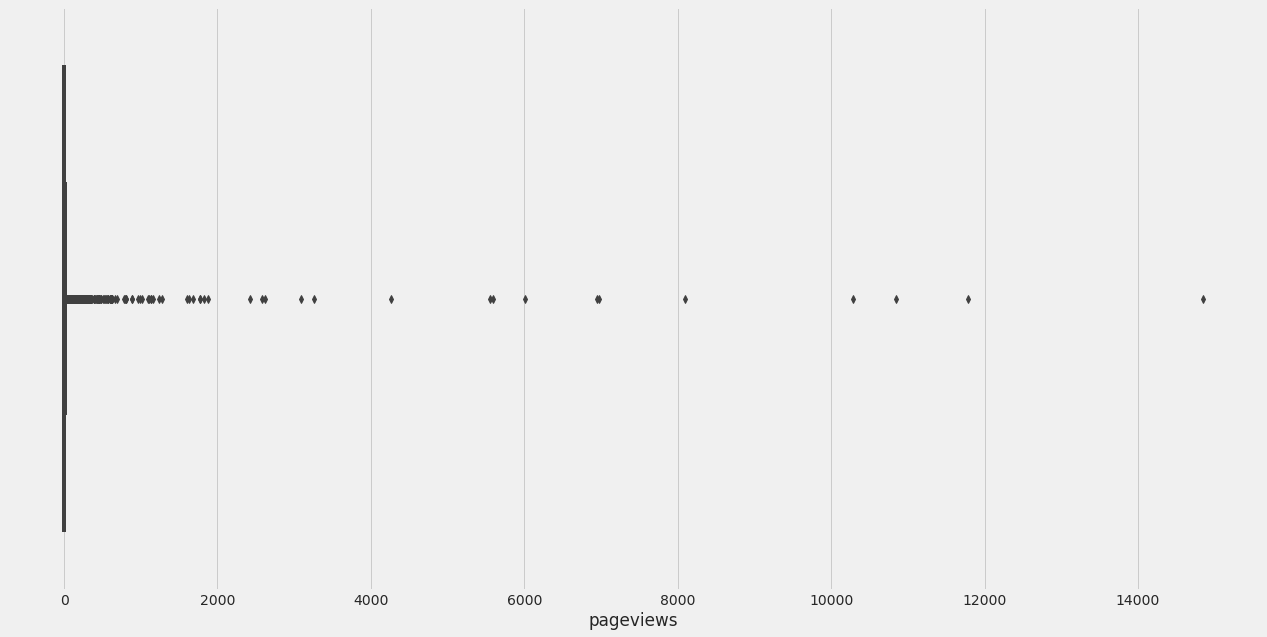

In [14]:
#box plot of total pageviews for each article
sns.boxplot(x=total_pv.pageviews);

In [15]:
for i in np.arange(0.1,1,0.1):
    print(round((i*100),0),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

10.0 th Percentile of Total Pageviews:  1.0
20.0 th Percentile of Total Pageviews:  1.0
30.0 th Percentile of Total Pageviews:  1.0
40.0 th Percentile of Total Pageviews:  1.0
50.0 th Percentile of Total Pageviews:  1.0
60.0 th Percentile of Total Pageviews:  2.0
70.0 th Percentile of Total Pageviews:  2.0
80.0 th Percentile of Total Pageviews:  3.0
90.0 th Percentile of Total Pageviews:  6.0


In [16]:
for i in np.arange(0.9,1,0.01):
    print(round((i*100),0),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

90.0 th Percentile of Total Pageviews:  6.0
91.0 th Percentile of Total Pageviews:  6.0
92.0 th Percentile of Total Pageviews:  7.0
93.0 th Percentile of Total Pageviews:  8.0
94.0 th Percentile of Total Pageviews:  10.0
95.0 th Percentile of Total Pageviews:  11.0
96.0 th Percentile of Total Pageviews:  14.0
97.0 th Percentile of Total Pageviews:  18.0
98.0 th Percentile of Total Pageviews:  27.0
99.0 th Percentile of Total Pageviews:  52.0


In [17]:
for i in np.arange(0.99,1,0.001):
    print(round((i*100),2),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

99.0 th Percentile of Total Pageviews:  52.0
99.1 th Percentile of Total Pageviews:  56.0
99.2 th Percentile of Total Pageviews:  65.0
99.3 th Percentile of Total Pageviews:  74.4230000000025
99.4 th Percentile of Total Pageviews:  87.93400000000838
99.5 th Percentile of Total Pageviews:  108.0
99.6 th Percentile of Total Pageviews:  135.9559999999983
99.7 th Percentile of Total Pageviews:  173.0
99.8 th Percentile of Total Pageviews:  252.93400000000838
99.9 th Percentile of Total Pageviews:  542.2910000001648
100.0 th Percentile of Total Pageviews:  14847.0


In [18]:
for i in np.arange(0.999,1,0.0001):
    print(round((i*100),3),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

99.9 th Percentile of Total Pageviews:  542.2910000001648
99.91 th Percentile of Total Pageviews:  602.7603999999992
99.92 th Percentile of Total Pageviews:  620.1295999999857
99.93 th Percentile of Total Pageviews:  765.7030999996714
99.94 th Percentile of Total Pageviews:  911.0049999996263
99.95 th Percentile of Total Pageviews:  1128.3789999998553
99.96 th Percentile of Total Pageviews:  1607.0855999999767
99.97 th Percentile of Total Pageviews:  1857.6284000002488
99.98 th Percentile of Total Pageviews:  3356.3867999958893
99.99 th Percentile of Total Pageviews:  6958.075799999875
100.0 th Percentile of Total Pageviews:  14846.999999977663


In [19]:
#filtering articles with top 0.001th percentile
data_filter =total_pv[total_pv['pageviews'] >= total_pv.pageviews.quantile(0.999)]
natids_filter=data_filter.natid.unique().tolist()
print(len(natids_filter))


55


In [20]:
df_fil=df_fil_day[df_fil_day['natid'].isin (natids_filter)]
print(df_fil.shape)
print('Number of Unique Articles: ', len(df_fil.natid.unique()))

(9769, 11)
Number of Unique Articles:  55


In [21]:
#List of natural Ids of articles
natids=df_fil.natid.unique().tolist()
len(natids)

55

In [22]:
#helper function to create data 
def create_dataframe(natural_ids,df,date,time_from,time_to):
    
    #create dummy dataframe
    res = pd.DataFrame()
    
    for natid in natural_ids:
        #creating a new data frame tm - it has every minute of a day
        tm = (pd.DataFrame(natid,columns=['natid'],
                          index=pd.date_range(f'{date}'+'T00:00:00', f'{date}'+'T23:59:59',freq='1T'))
              .between_time(f'{time_from}',f'{time_to}')
              .reset_index()
        )
        tm.columns=['day_time','natid']
        tm['day_time']=pd.to_datetime(tm['day_time'])
        
        #filter data for each article
        test=df[df['natid']==natid]
        
        #time difference
        time_diff_before=(test['day_time'].tolist()[0])-timedelta(minutes=15)     
        
        time_diff_after=(test['day_time'].tolist()[-1])+timedelta(minutes=5)  
        
        # Merge with the test df
        #first data point always zero, we can change it
     
        test = pd.merge(
            test,
            tm,
            on=['day_time','natid'],
            how='right'
        )
        
        #rolling sum
        #creating cumulative pageviews
        test['pageviews'] =test['pageviews'].fillna(0)
        test['rolling_pv'] =test['pageviews'].rolling(15).sum() # we can change "n"
        test['rolling_pv'] =test['rolling_pv'].fillna(0)
       
        test['return_rolling_pv']=test['rolling_pv'].pct_change(1)
        test['return_rolling_pv']=test['return_rolling_pv'].fillna(0)
        test['return_rolling_pv'] = np.where(test['return_rolling_pv'] == math.inf,
                                             test['rolling_pv'], test['return_rolling_pv'])
        

        #filter data 
        test=test[test['day_time']>time_diff_before]
        
        test=test[test['day_time']<time_diff_after]
        
        res=res.append(test)
        
    return res

In [23]:
#taking data for time between 6am to 10am
data=create_dataframe(natids,df_fil,date,str(frm),str(to))
data.shape

(9955, 13)

### Best Perfroming Articles:

In [24]:
#helper function to calculate sharpe ratio
def sharpe_ratio(df):
    return df['return_rolling_pv'].mean() /df['return_rolling_pv'].std()

In [25]:
#helper function to calculate coefficient of variation
def coefficient_variation(df):
    return df['rolling_pv'].mean() /df['rolling_pv'].std()

In [26]:
#descriptive stats
stat=data.groupby('natid')['rolling_pv'].describe().reset_index()
#skew
skew=data.groupby('natid').agg(skew = pd.NamedAgg(column="rolling_pv", aggfunc="skew"))
#kurtois
kurt=data.groupby('natid').agg( kurt =  pd.NamedAgg(column="rolling_pv", aggfunc=pd.DataFrame.kurt))
#sharpe ratio
sharpe_ratio = data.groupby('natid').apply(sharpe_ratio)
sharpe_ratio=pd.DataFrame({'natid':sharpe_ratio.index, 'sharpe_ratio':sharpe_ratio.values})

#coefficient of variation
cv = data.groupby('natid').apply(coefficient_variation)
cv=pd.DataFrame({'natid':cv.index, 'cv':cv.values})

In [27]:
#merging all data
stat = pd.merge(stat,skew,on=['natid'],how='right')
stat = pd.merge(stat,kurt,on=['natid'],how='right')
stat = pd.merge(stat,sharpe_ratio,on=['natid'],how='right')
stat = pd.merge(stat,cv,on=['natid'],how='right')


In [28]:
stat = stat.sort_values(by=['max','cv','sharpe_ratio'], ascending=False)
stat.head()

,natid,count,mean,std,min,25%,50%,75%,max,skew,kurt,sharpe_ratio,cv
34,blogandpostid/blog/post/51339-638e97f8ffde4c00...,181.0,1137.983425,430.366775,0.0,907.0,1222.0,1478.0,1697.0,-1.173006,1.285384,0.074358,2.644218
15,blogandpostid/blog/post/4970-63405a74ca7f6d000...,181.0,811.270718,333.233066,0.0,613.0,814.0,1057.0,1380.0,-0.778337,0.465714,0.074404,2.434544
23,blogandpostid/blog/post/50356-638e4d0140013d00...,181.0,521.812155,391.311680,0.0,182.0,450.0,859.0,1307.0,0.563001,-1.012666,0.074305,1.333495
9,blogandpostid/blog/post/2282-638b8e5fedcf34000...,181.0,909.331492,320.368088,0.0,792.0,1033.0,1144.0,1234.0,-1.638908,2.395932,0.074393,2.838396
6,blogandpostid/blog/post/1360-638bfefcf4926f000...,181.0,843.342541,268.023224,0.0,856.0,939.0,976.0,1095.0,-2.389213,4.935826,0.074318,3.146528


## Momentum Indicators

### Combined method: Bollinger Bands + RSI



In [29]:
#sma
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

In [30]:
#Bollinger Bands
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 1.5
    return upper_bb

In [31]:
def momentum(data,natids):
    #create dummy dataframe
    res = pd.DataFrame()
    
    for natid in natids:
        df=data[data['natid']==natid]
        
        #creating SMA
        df['sma'] = sma(df['rolling_pv'], 7)
        df['sma'] = df['sma'].fillna(0)
        
        #creating upper and lower bands
        df['upper_bb'] = bb(df['rolling_pv'], df['sma'], 15)
        df['upper_bb'] = df['upper_bb'].fillna(0)
        # RSI
        df['rsi'] = df['upper_bb'].transform(lambda x: talib.RSI(x, timeperiod=7))
        df['rsi'] = df['rsi'].fillna(0)
        
        res=res.append(df)
        
    return res

### Top Perfroming

In [32]:
#define number of articles
n=10
top_natids=stat['natid'][0:n].tolist()

print(len(top_natids))

10


In [33]:
top_perf=data[data['natid'].isin (top_natids)]
top_perf.shape

(1810, 13)

In [34]:
#Creating Momentum Indicators
final=momentum(top_perf,top_natids)


In [35]:
#final output
out=final[['natid','title','day_time','pageviews','rolling_pv','rsi']]
out['title'] = out.groupby(['natid'])['title'].bfill()
out['title'] = out.groupby(['natid'])['title'].ffill()
out.head()

,natid,title,day_time,pageviews,rolling_pv,rsi
0,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 06:00:00,66.0,0.0,0.0
1,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 06:01:00,45.0,0.0,0.0
2,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 06:02:00,63.0,0.0,0.0
3,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 06:03:00,67.0,0.0,0.0
4,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 06:04:00,55.0,0.0,0.0


In [36]:
out.title.unique().tolist()

['Elon Musk Has Outfitted Twitter’s Headquarters With Bedrooms For Employees',
 'London’s Culture Crush: What To See, Do And Experience In December',
 'Ukrainian Drones Just Took Out A Russian Heavy Bomber 300 Miles From Ukraine',
 'Trump Owed Hidden Debt While In Office',
 'Today’s Wordle #535 Hints, Clues And Answer For Tuesday, December 6th',
 'Tamara Mellon On Her Celestial-Inspired A/W22 Collection',
 'Ukraine Pulled Ex-Soviet Recon Drones Out Of Storage, Added Bombs And Sent Them Hurtling Toward Russia',
 '2022 Major Layoffs Grow: PepsiCo Laying Off Hundreds Of Staff, Report Says',
 'Ex-Twitter Employees Begin Lawyering Up To Face Elon Musk',
 'Here’s Exactly When ‘Overwatch 2’ Season 2 Goes Live']

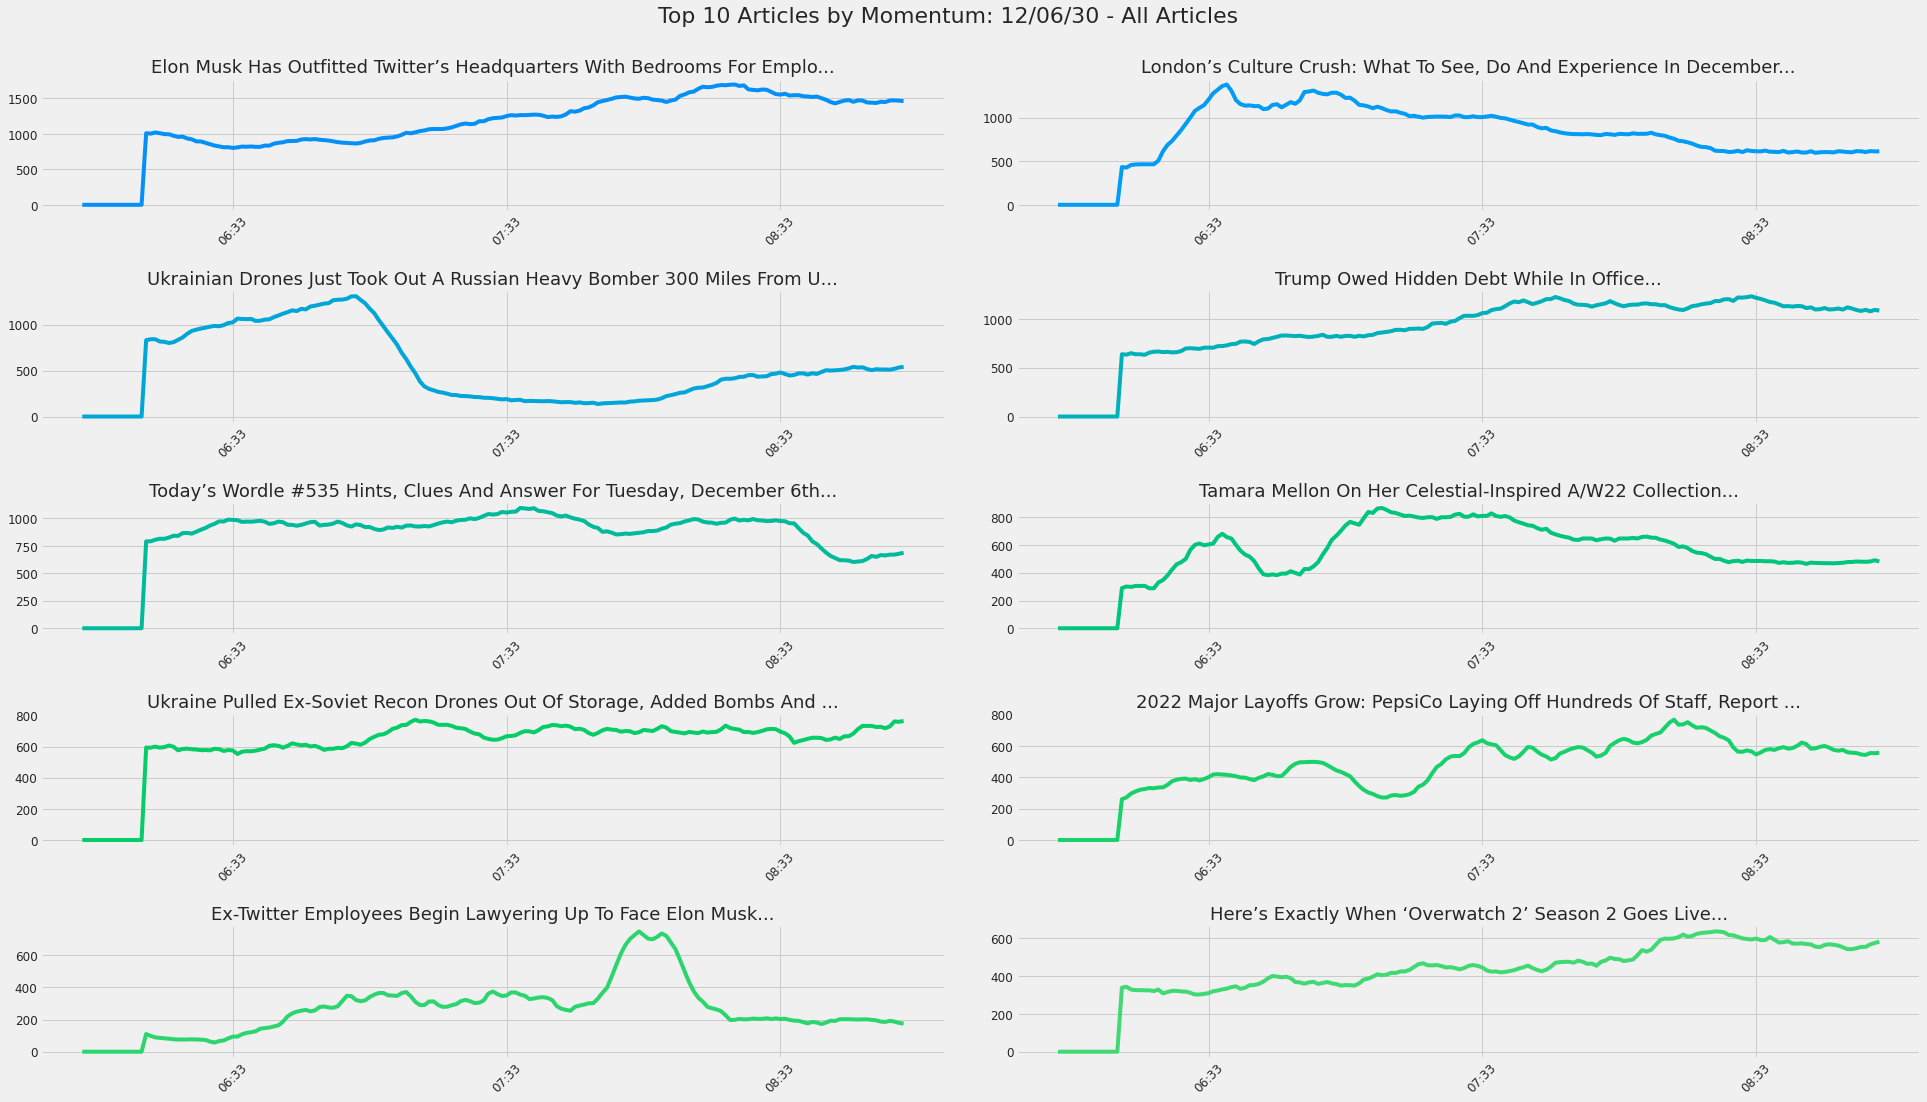

In [37]:
ten_charts(
    df=out,
    fn='top_6am-9am_06Dec_all_articles',
    title='Top 10 Articles by Momentum: 12/06/30 - All Articles'
)

### Bottom




In [38]:
stat.tail(10)

,natid,count,mean,std,min,25%,50%,75%,max,skew,kurt,sharpe_ratio,cv
38,blogandpostid/blog/post/51554-638e52477185e600...,181.0,42.635359,18.704713,0.0,34.0,42.0,52.0,79.0,-0.374447,0.337650,0.077445,2.279391
49,blogandpostid/blog/post/7227-638e0554edcf34000...,181.0,46.436464,15.733990,0.0,42.0,51.0,54.0,78.0,-1.787683,3.476753,0.075271,2.951347
1,blogandpostid/blog/post/1174-638c9bdaedcf34000...,181.0,47.961326,17.568711,0.0,39.0,53.0,58.0,76.0,-1.375056,1.880335,0.076797,2.729929
19,blogandpostid/blog/post/5015-638e592429701d000...,181.0,47.613260,19.033440,0.0,36.0,54.0,61.0,76.0,-1.055026,0.620919,0.075353,2.501558
31,blogandpostid/blog/post/51239-6352d8c9bb15bb00...,181.0,46.486188,16.500710,0.0,40.0,49.0,57.0,72.0,-1.485805,2.416252,0.076810,2.817224
10,blogandpostid/blog/post/2799-6335b3e2e39b58000...,181.0,50.950276,16.638401,0.0,49.0,55.0,60.0,71.0,-2.131911,4.194645,0.075587,3.062210
0,blogandpostid/blog/post/1114-6384385ce92904000...,181.0,46.419890,15.204548,0.0,44.0,48.0,54.0,69.0,-2.003467,4.219005,0.074865,3.053027
2,blogandpostid/blog/post/1174-638ca7b6c8f680000...,181.0,47.370166,15.839507,0.0,44.0,51.0,56.0,69.0,-1.902071,3.651044,0.074634,2.990634
28,blogandpostid/blog/post/50725-638c13798548bc00...,181.0,44.182320,15.302684,0.0,40.0,49.0,53.0,65.0,-1.744415,2.830292,0.076243,2.887227
40,blogandpostid/blog/post/5660-638c9560c8f680000...,181.0,43.320442,15.050547,0.0,38.0,46.0,53.0,65.0,-1.652271,2.773308,0.075325,2.878330


In [39]:
bottom_natids=stat['natid'][-n:].tolist()
print(len(bottom_natids))
worst_perf=data[data['natid'].isin (bottom_natids)]
worst_perf.shape

10


(1810, 13)

In [40]:
#Creating Momentum Indicators
bottom=momentum(worst_perf,bottom_natids)
bottom.head()

,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date,time,day_time,rolling_pv,return_rolling_pv,sma,upper_bb,rsi
0,blogandpostid/blog/post/51554-638e52477185e600...,NaN,NaT,NaN,NaT,0.0,NaN,NaN,NaT,NaN,2022-12-06 06:00:00,0.0,0.0,0.0,0.0,0.0
1,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-05,15:22:42,2022-12-05 15:22:42,2.0,6.0,1.0,2022-12-06,06:01:00,2022-12-06 06:01:00,0.0,0.0,0.0,0.0,0.0
2,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-05,15:22:42,2022-12-05 15:22:42,3.0,6.0,2.0,2022-12-06,06:02:00,2022-12-06 06:02:00,0.0,0.0,0.0,0.0,0.0
3,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-05,15:22:42,2022-12-05 15:22:42,4.0,6.0,3.0,2022-12-06,06:03:00,2022-12-06 06:03:00,0.0,0.0,0.0,0.0,0.0
4,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-05,15:22:42,2022-12-05 15:22:42,1.0,6.0,4.0,2022-12-06,06:04:00,2022-12-06 06:04:00,0.0,0.0,0.0,0.0,0.0


In [41]:
#final output
out_bottom=bottom[['natid','title','day_time','pageviews','rolling_pv','rsi']]
out_bottom['title'] = out_bottom.groupby(['natid'])['title'].bfill()
out_bottom['title'] = out_bottom.groupby(['natid'])['title'].ffill()
out_bottom.head()

,natid,title,day_time,pageviews,rolling_pv,rsi
0,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-06 06:00:00,0.0,0.0,0.0
1,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-06 06:01:00,2.0,0.0,0.0
2,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-06 06:02:00,3.0,0.0,0.0
3,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-06 06:03:00,4.0,0.0,0.0
4,blogandpostid/blog/post/51554-638e52477185e600...,Trump Backtracks On Calling For ‘Termination’ ...,2022-12-06 06:04:00,1.0,0.0,0.0


In [42]:
out_bottom.title.unique().tolist()

['Trump Backtracks On Calling For ‘Termination’ Of Constitution Following Backlash',
 'Oil Surges As Russian Oil Price Cap Kicks In—Here’s How High Experts Predict It Could Go',
 'Here Are All The ‘Fortnite’ Chapter 4 Battle Pass Skins And Cosmetics',
 'Dow Falls 500 Points As Experts Debate Whether Stock Market Will Crash Again Soon',
 'Kanye West’s Antisemitic, Troubling Behavior—Here’s Everything He’s Said In Recent Weeks',
 'Meet The Most Successful Female Entrepreneur In American History',
 'Russia’s Economic Prospects Have Gone From Bad To Terrible',
 'The Best ‘Marvel Snap’ Destroy Deck For Climbing The Ladder',
 'Sarah Jessica Parker Opens Up About Business, Family And ‘The Perfect Cosmo’ This Holiday Season',
 '‘The Next Generation’—BlackRock CEO Reveals $8 Trillion Fund’s Huge Crypto Prediction After Bitcoin And Ethereum Price Crash']

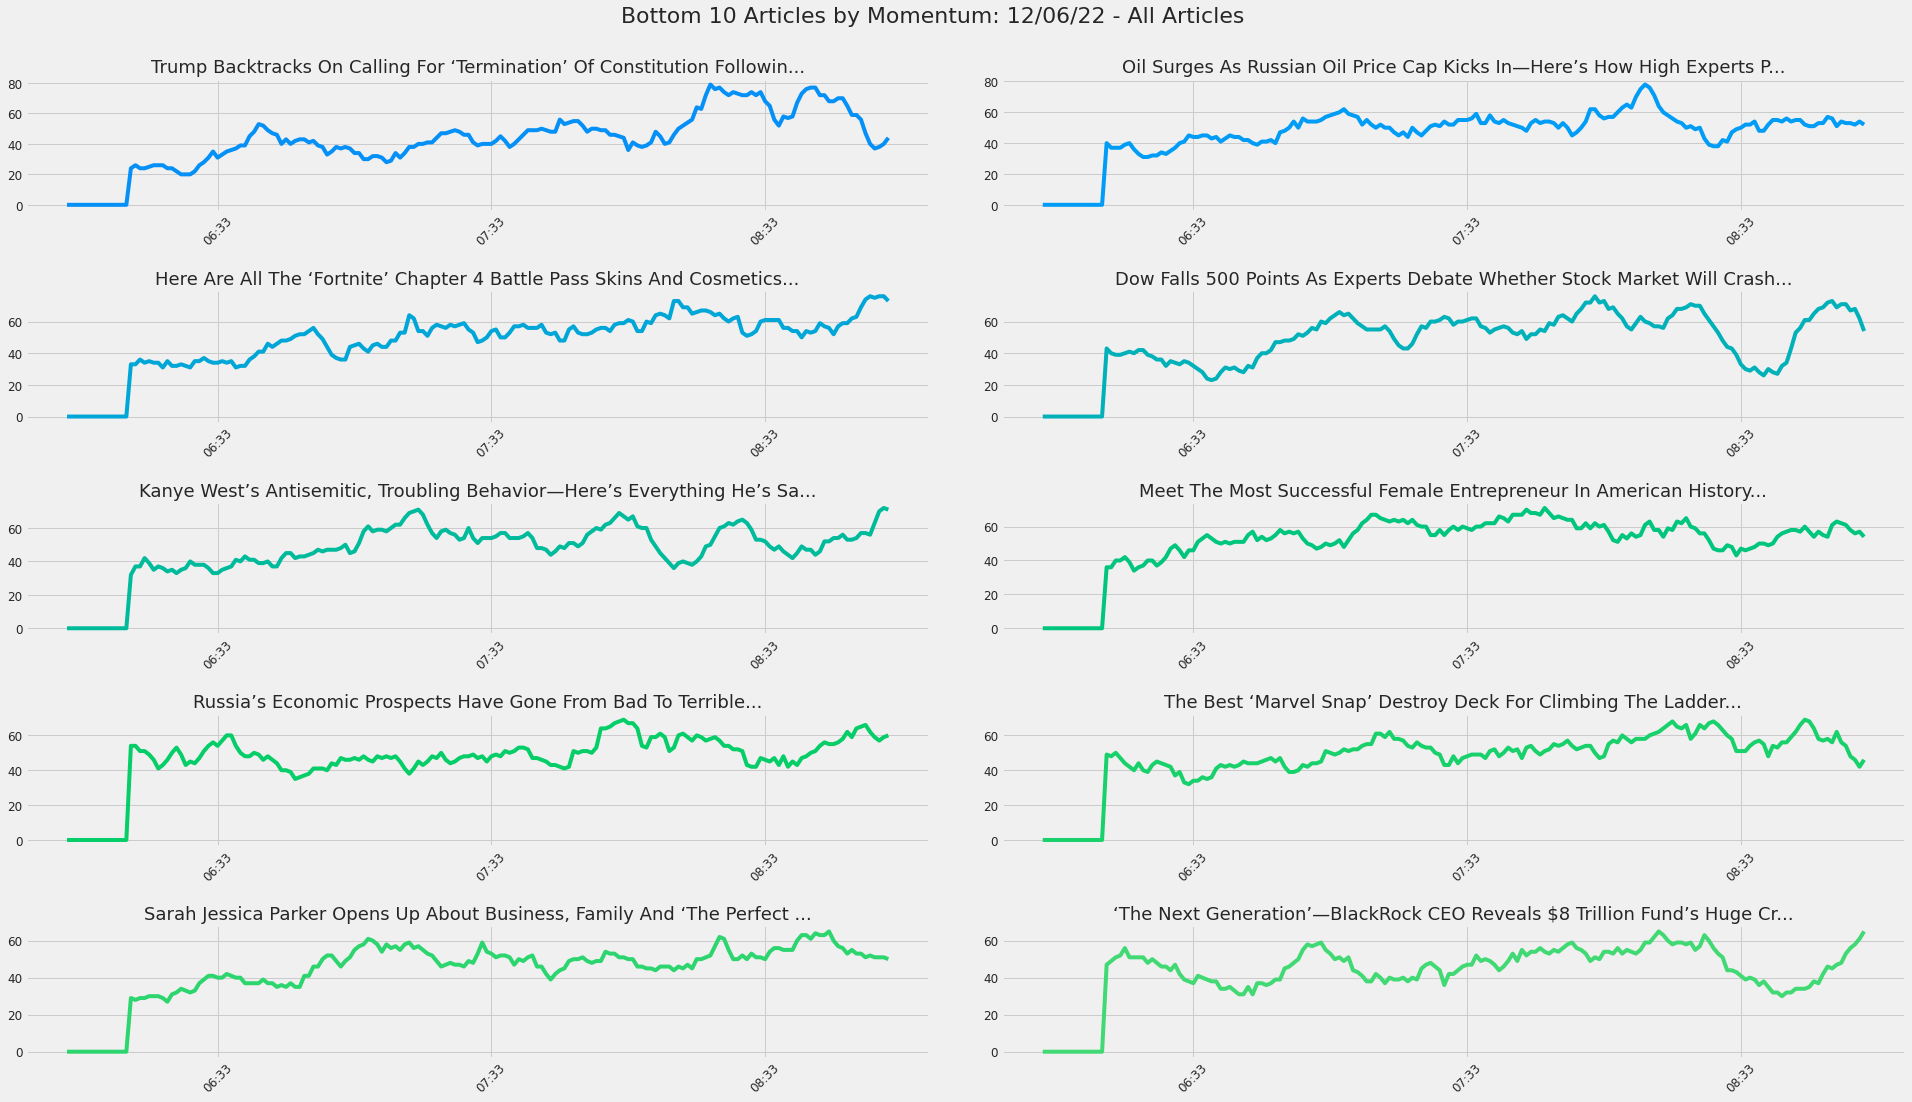

In [43]:
ten_charts(
    df=out_bottom,
    fn='Bottom_6am-9am_05Dec_all_articles',
    title='Bottom 10 Articles by Momentum: 12/06/22 - All Articles'
)